In [1]:
%load_ext memory_profiler
import os
import tensorflow as tf
import warnings
import numpy as np
import pandas as pd
import scanpy as sc

warnings.simplefilter(action='ignore', category=FutureWarning)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

from scgamnn import scGAMNN
from utils import *
from metrics import *
warnings.filterwarnings("ignore")

sc.settings.verbosity = 3
sc.settings.set_figure_params(dpi=100)
sc.settings.set_figure_params(dpi_save=300)
sc.logging.print_version_and_date()

Running Scanpy 1.9.1, on 2023-07-13 12:41.


In [2]:
adata=sc.read_csv("E:/scGAMNN/data/pancreas/log_pancreas.csv")
ident1 = pd.read_csv("E:/scGAMNN/data/pancreas/label1.csv")
ident2 = pd.read_csv("E:/scGAMNN/data/pancreas/label2.csv")
ident3 = pd.read_csv("E:/scGAMNN/data/pancreas/label3.csv")
ident4 = pd.read_csv("E:/scGAMNN/data/pancreas/label4.csv")
idents= np.vstack((ident1,ident2,ident3,ident4))
adata.obs['celltype'] = idents
match = np.array(pd.read_csv("E:/scGAMNN/data/pancreas/match.csv"))
adata.obs["batch"] = np.array([1] * len(ident1) + [2] * len(ident2)+[3] * len(ident3) + [4] * len(ident4))
sc.pp.scale(adata, max_value=10)
sc.tl.pca(adata, svd_solver='arpack')
adatas = [adata[adata.obs['batch'] == i,:].copy() for i in [1,2,3,4]]
adj,adj_n=construct_graph(adatas,match)

computing PCA
    with n_comps=50
    finished (0:00:01)


In [3]:
model = scGAMNN(adata.X, adj, adj_n, match=match,hidden_dim=120, latent_dim=50, decA="DBL", layer_enc="GCN")

import time
time_s = time.time()
%memit model.train(epochs=200, W_a=1, W_x=1, W_w=0.1)
print('time used:', time.time()-time_s)

Epoch 1  X_rec_loss: 0.88223976   A_rec_loss: 0.5395174   MNN_loss: 0.5395174  total_loss:  1.5700842
Learning rate = 0.0020000
Epoch 2  X_rec_loss: 0.86999327   A_rec_loss: 0.065005936   MNN_loss: 0.065005936  total_loss:  1.107818
Learning rate = 0.0020000
Epoch 3  X_rec_loss: 0.8486928   A_rec_loss: 0.023657965   MNN_loss: 0.023657965  total_loss:  1.0733693
Learning rate = 0.0020000
Epoch 4  X_rec_loss: 0.81982416   A_rec_loss: 0.0023583036   MNN_loss: 0.0023583036  total_loss:  1.04522
Learning rate = 0.0020000
Epoch 5  X_rec_loss: 0.793351   A_rec_loss: 0.0019256062   MNN_loss: 0.0019256062  total_loss:  1.0328213
Learning rate = 0.0020000
Epoch 6  X_rec_loss: 0.76725984   A_rec_loss: 0.0019249478   MNN_loss: 0.0019249478  total_loss:  1.0143974
Learning rate = 0.0020000
Epoch 7  X_rec_loss: 0.75332195   A_rec_loss: 0.0019249378   MNN_loss: 0.0019249378  total_loss:  1.0027274
Learning rate = 0.0020000
Epoch 8  X_rec_loss: 0.74139786   A_rec_loss: 0.0019249378   MNN_loss: 0.00192

Epoch 63  X_rec_loss: 0.6164027   A_rec_loss: 0.0023501157   MNN_loss: 0.0023501157  total_loss:  0.67866397
Learning rate = 0.0012800
Epoch 64  X_rec_loss: 0.6165617   A_rec_loss: 0.0022844847   MNN_loss: 0.0022844847  total_loss:  0.67754644
Learning rate = 0.0012800
Epoch 65  X_rec_loss: 0.61503035   A_rec_loss: 0.0022810781   MNN_loss: 0.0022810781  total_loss:  0.6755836
Learning rate = 0.0012800
Epoch 66  X_rec_loss: 0.6142344   A_rec_loss: 0.0022525652   MNN_loss: 0.0022525652  total_loss:  0.6746309
Learning rate = 0.0012800
Epoch 67  X_rec_loss: 0.6128361   A_rec_loss: 0.002241633   MNN_loss: 0.002241633  total_loss:  0.67244613
Learning rate = 0.0012800
Epoch 68  X_rec_loss: 0.6131797   A_rec_loss: 0.0022618978   MNN_loss: 0.0022618978  total_loss:  0.6715601
Learning rate = 0.0012800
Epoch 69  X_rec_loss: 0.6124233   A_rec_loss: 0.0023041978   MNN_loss: 0.0023041978  total_loss:  0.67052287
Learning rate = 0.0012800
Epoch 70  X_rec_loss: 0.6127484   A_rec_loss: 0.0022860682 

computing neighbors
    using data matrix X directly
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:16)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:12)


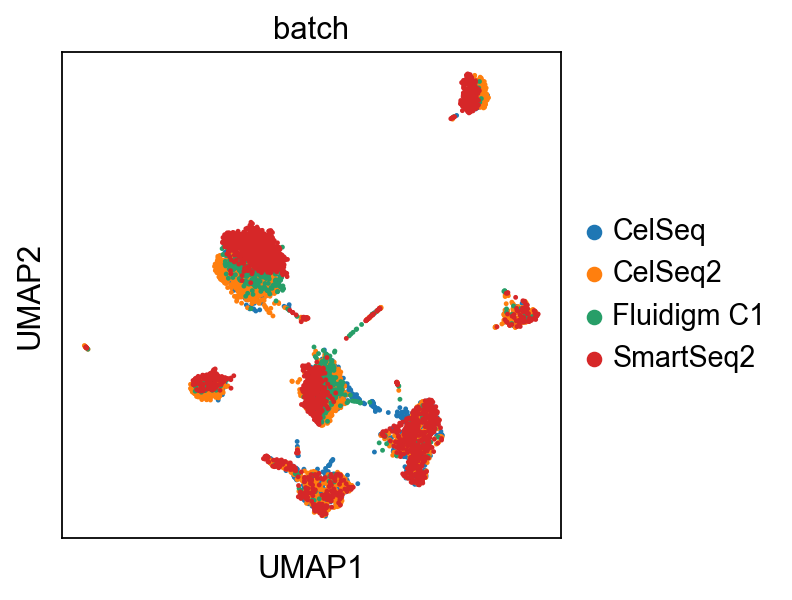

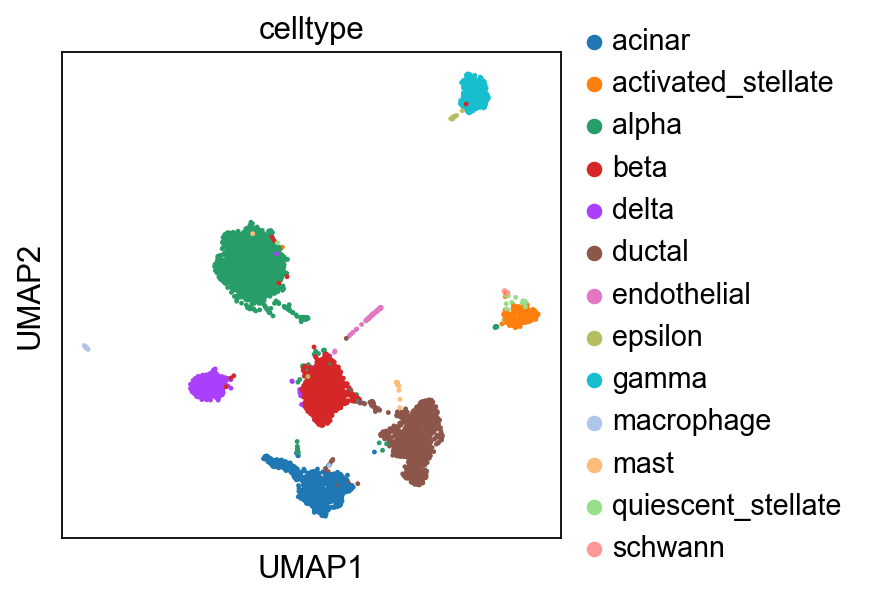

integrate ASW_c: 0.8155 ASW_b: 0.7193 


In [4]:

import anndata as ad
adata_scGAMNN=ad.AnnData(model.embedding(adata.X, adj_n))
sc.pp.neighbors(adata_scGAMNN)
sc.tl.umap(adata_scGAMNN)
adata_scGAMNN.obs['celltype'] = adata.obs['celltype'].to_list()
adata_scGAMNN.obs["batch"] = np.array(['CelSeq'] * len(ident1) + ['CelSeq2'] * len(ident2)+['Fluidigm C1'] * len(ident3) + ['SmartSeq2'] * len(ident4))
sc.pl.umap(adata_scGAMNN,color='batch')
sc.pl.umap(adata_scGAMNN,color='celltype')

inte_scGAMNN=integrate_indicators (np.array(adata_scGAMNN.obsm['X_umap']),np.array(adata_scGAMNN.obs['batch']),np.array(adata_scGAMNN.obs['celltype']))
inte_scGAMNN_df=pd.DataFrame.from_dict(inte_scGAMNN,orient='index').T


In [6]:
#13-------------------------
sc.tl.leiden(adata_scGAMNN,resolution=0.6)
cluster_scGAMNN=cluster_indicators (adata_scGAMNN.obs['leiden'],np.array(adata_scGAMNN.obs['celltype']))
cluster_scGAMNN_df=pd.DataFrame.from_dict(cluster_scGAMNN,orient='index').T

running Leiden clustering
    finished: found 14 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)
cluster nmi: 0.9116 ari: 0.9302 


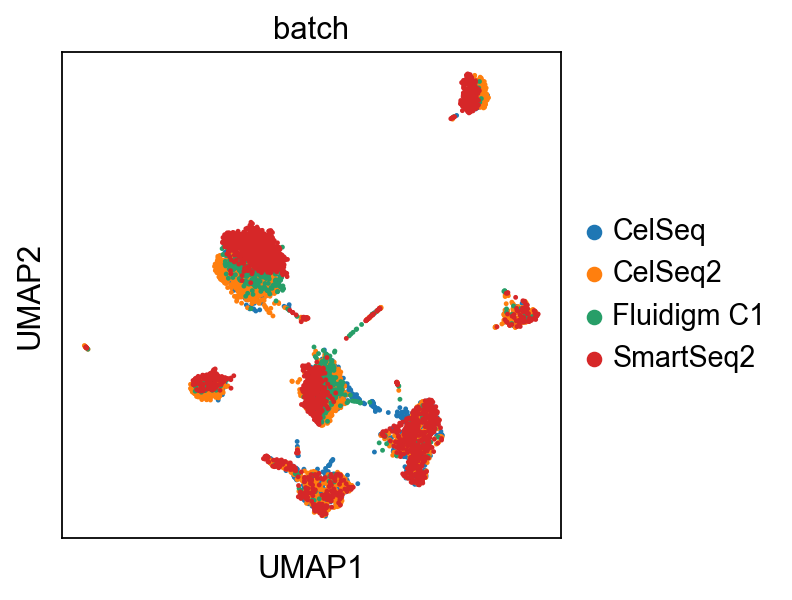

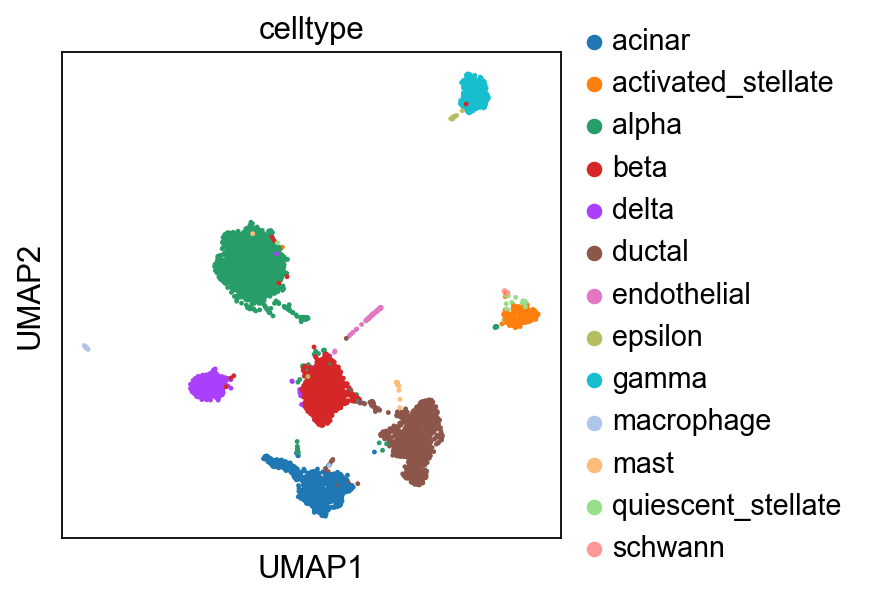

In [7]:
sc.pl.umap(adata_scGAMNN,color='batch',save='_pancreas_scGAMNN_batch.pdf')
sc.pl.umap(adata_scGAMNN,color='celltype',save='_pancreas_scGAMNN_celltype.pdf')

In [8]:
inte_scGAMNN_df.to_csv('result/inte_scGAMNN_pancreas.csv',index=0)
cluster_scGAMNN_df.to_csv('result/c_scGAMNN_pancreas.csv',index=0)

In [9]:
adata_scGAMNN.write('result/adata_scGAMNN_pancreas.h5ad')
#adata_scGAMNN= sc.read_h5ad('result/adata_scGAMNN_pancreas.h5ad')





In [10]:
entropy_scGAMNN=compute_entropy(adata_scGAMNN)
entropy_scGAMNN.to_csv('result/entropy_scGAMNN_pancreas.csv',index=0)

Calculating entropy ...
use exist neighbors
Entropy calculated!
